In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import math
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io import excel

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the road network
## Needs the road network

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path + scenario + '/'):
    os.makedirs(model_path + scenario + '/')

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_json(input_path + 'de_road_network')
ae = stepmodel.read_json(model_path + 'de_road_access_egress')
z = stepmodel.read_json(model_path + 'de_zones')

In [7]:
sm.zone_to_road = ae.zone_to_road
sm.centroids = ae.centroids
sm.zones = z.zones

In [8]:
len(sm.zone_to_road.loc[sm.zone_to_road['a'].str.startswith('DE'), 'a'].unique())

401

## Generate LoS attribute time
The maxspeed column is based on OSM data that needs to be refined. The unit is km/h

array([[<AxesSubplot:title={'center':'maxspeed'}>]], dtype=object)

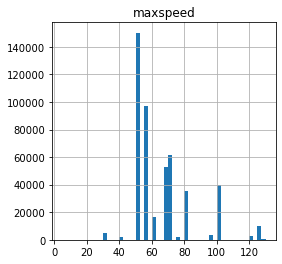

In [9]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [10]:
sm.road_links['maxspeed'].unique()

array([ 80,  57,  50,  70, 100,  30,  68,  60,  76, 125,  96,  40, 120,
       130,  90,  10,  20,   5,  65], dtype=int64)

Now, generate travel time based on the information available. In many transport models, time depends on the network flow. As a simplification for this long-term strategic model in times of modern traffic management, we assume speed limits to be equilibrated with the traffic situation. Hence, travel time depends on speed limits.

In a [publication by the Federal Environmental Agency](https://www.umweltbundesamt.de/publikationen/klimaschutz-durch-tempolimit), the following average speeds were found on the respective road sections:
- Speed limit | average traffic flow speed 
- <=60 | 60
- 80 | 87.4
- 100 | 103.3
- 120 | 115.6
- 130 | 118.3
- open | 124.7

The following calculations approximate these figures.

In [20]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits

# For up to 60km/h average speed equals the speed limit
mask60 = sm.road_links['maxspeed']<=60
sm.road_links.loc[mask60, 'time'] = sm.road_links['length'] / 1000 / sm.road_links['maxspeed'] * 3600

# Then, up to under 100km/h, average speeds are 10% above the speed limit
mask100 = sm.road_links['maxspeed']<100
sm.road_links.loc[(~mask60)&(mask100), 'time'] = \
    sm.road_links['length'] / 1000 / sm.road_links['maxspeed'] * 3600 * 1.1

# Then, speed follows a polynomial of y = -0,0115x2 + 3,145x - 96,2 (R^2=1)
mask_not_open = sm.road_links['maxspeed']!=125
sm.road_links.loc[(~mask100)&(mask_not_open), 'time'] = sm.road_links['length'] / 1000 / \
    (-0.0115*np.power(sm.road_links['maxspeed'], 2) + 3.145*sm.road_links['maxspeed'] - 96.2) * 3600

assert len(sm.road_links[sm.road_links['time'].isna()])==0
sm.road_links.loc[sm.road_links['time']==0, 'time'] = 1

<AxesSubplot:>

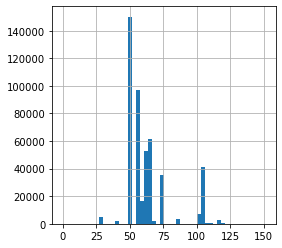

In [22]:
# Average speed by number of links (not length)
(sm.road_links['length'] / 1000 / sm.road_links['time'] * 3600).hist(bins=50, figsize=(4,4))

In [23]:
sm.road_links.sample(2)

,a,b,maxspeed,length,time,geometry,lanes
index,,,,,,,
rl_39510,262205537,274805656,57,342,21.600,"LINESTRING (7.58722 52.30022, 7.59222 52.30057)",3
rl_378128,30558123,30558111,50,17,1.224,"LINESTRING (13.43200 52.59407, 13.43225 52.59405)",None


### Alter road access/egress links

In [24]:
# Assign a time
sm.zone_to_road['time'] = params['access-egress_links']['time_road']

## Apply road pathfinder in order to generate LoS table

In [25]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + scenario + '/de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

The volumes file is not (yet) available


In [26]:
sm.step_road_pathfinder(all_or_nothing=True,
                        od_set=od_set)

In [27]:
sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs
90953,DE943,DEB3I,18604.610892,"[DE943, 26869979, 26869985, 26869977, 31065896...","[26869979, 26869985, 26869977, 31065896, 28662...","[rl_83930, rl_83932, rl_83929, rl_85087, rl_32...","[(DE943, 26869979), (255305396, DEB3I)]"


In [28]:
sm.car_los.shape

(160801, 7)

In [29]:
# Verify with Google maps routing
# Berlin (DE300) - Stade (DE939): 4h22m, 354km
# Berlin (DE300) - Stuttgart (DE111): 6h37m, 632km
# Berlin (DE300) - Stendal (DEE0D): 2h08m, 125km
# Stade (DE939) - Stuttgart (DE111): 7h45m, 687km
# Stendal (DEE0D) - Stuttgart (DE111): 6h11m, 574km
# Stendal (DEE0D) - Stade (DE939): 3h22m, 231km
od = ['DE300', 'DE939', 'DE111', 'DEE0D']
for _, row in sm.car_los.loc[(sm.car_los['origin'].isin(od)) &
                             (sm.car_los['destination'].isin(od))].iterrows():
    print(row['origin'] + ' - ' + row['destination'] + ': '
          + str(np.round(row['time']/3600,1)) + ', '
          + str(int(sm.road_links.loc[row['link_path'], 'length'].sum()/1000)) + 'km')

DE111 - DE111: 0.0, 0km
DE111 - DE300: 6.4, 613km
DE111 - DE939: 7.1, 660km
DE111 - DEE0D: 6.5, 559km
DE300 - DE111: 6.4, 612km
DE300 - DE300: 0.0, 0km
DE300 - DE939: 3.8, 326km
DE300 - DEE0D: 2.2, 128km
DE939 - DE111: 7.1, 660km
DE939 - DE300: 3.8, 329km
DE939 - DE939: 0.0, 0km
DE939 - DEE0D: 3.2, 208km
DEE0D - DE111: 6.5, 557km
DEE0D - DE300: 2.1, 128km
DEE0D - DE939: 3.2, 208km
DEE0D - DEE0D: 0.0, 0km


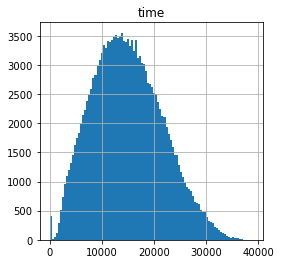

In [30]:
if manual: sm.car_los.hist(column='time', bins=100, figsize=(4,4))

In [31]:
# Drop inner-cell connections
sm.car_los = sm.car_los[sm.car_los['time']!=0]
sm.car_los.shape

(160400, 7)

## Add various attributes to LoS table

In [32]:
# Disaggregate into in-vehicle time and access/egress
sm.analysis_car_time()
sm.car_los.columns

Index(['origin', 'destination', 'time', 'path', 'node_path', 'link_path',
       'ntlegs', 'access_time', 'in_vehicle_time'],
      dtype='object')

In [33]:
# Add distances car
len_dict = sm.road_links['length'].to_dict()
sm.car_los['length'] = sm.car_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [34]:
# Add route_type = 'car' in car_los
sm.analysis_car_route_type()

In [35]:
#sm.car_los['ntransfers'] = 0

## Save model

In [36]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.car_los = sm.car_los.drop(to_drop, axis=1, errors='ignore')

In [37]:
sm.car_los.columns

Index(['origin', 'destination', 'time', 'link_path', 'access_time',
       'in_vehicle_time', 'length', 'route_types', 'route_type'],
      dtype='object')

In [38]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [39]:
sm.to_json(model_path + scenario + '/' + 'de_road_los',
           only_attributes=['car_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.49it/s]


In [40]:
# Also save road links with imputated maxspeeds
sm.road_links["time"] = sm.road_links["time"].astype(int)
sm.to_json(input_path + 'de_road_network', only_attributes=
           ['road_links', 'road_nodes', 'zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [01:38<00:00,  2.88s/it]
